In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from VelocityDispersionLibrary import Sigma
from tqdm.notebook import tqdm
import sys
sys.path.insert(1, "/Users/chris/Documents/PhD/ProjectSigma/GalaxyTools")
from darkmatter import getC
from HM2SM import stellar_mass_to_halo_mass
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')

In [2]:
df = pd.read_csv("/Users/chris/data/MANGa/MANGa.csv")

print(list(df))

print(len(df))

ellipticals = df[ (df['TTYPE'] > -8) & (df['TTYPE'] < 0) & (df['P_S0'] > 0.5)]

['Unnamed: 0', 'INTID', 'RA', 'DEC', 'z', 'BT', 'Bulge_axis_ratio', 'Bulge_major_axis_arcsecs', 'FLAG_FIT', 'Bulge_n', 'Disk_position_angle', 'TTYPE', 'P_S0', 'P_MERG', 'P_BULGE', 'cont', 'Vmax', 'sigma_re', 'sigma_ap', 'catmasssetrunc', 'catmassstrunc', 'abs_mag', 're', 're_kpc', 'Mstar']
2872


(array([470., 146.,  35.,  11.,   9.,   2.,   2.,   0.,   0.,   1.]),
 array([2.77200015e-03, 2.39427527e+00, 4.78577854e+00, 7.17728182e+00,
        9.56878509e+00, 1.19602884e+01, 1.43517916e+01, 1.67432949e+01,
        1.91347982e+01, 2.15263014e+01, 2.39178047e+01]),
 <a list of 10 Patch objects>)

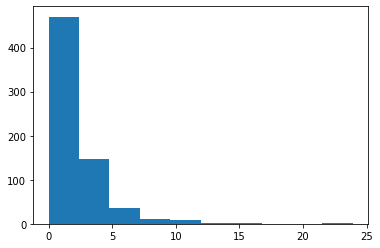

In [3]:
sdss_ap_kpc = cosmo.angularDiameterDistance(np.array(ellipticals['z']))*1.4544e-5 * 1000


mean_axis_ratio = (np.array(ellipticals['Bulge_axis_ratio']) + 1)/2
bulge_axis_radians = np.radians(np.array(ellipticals['Bulge_major_axis_arcsecs'])/(60*60))*mean_axis_ratio 

new_re_kpc = cosmo.angularDiameterDistance(np.array(ellipticals['z']))*bulge_axis_radians*1000

plt.hist(np.array(ellipticals['Bulge_major_axis_arcsecs']))


In [4]:
print(len(np.array(ellipticals['Mstar'])), len(np.array(ellipticals['z'])) )

halo_masses = stellar_mass_to_halo_mass(np.array(ellipticals['Mstar']),  np.array(ellipticals['z']))

BT = np.array(ellipticals['BT'])
Mstar = np.array(ellipticals['Mstar'])

sigma = Sigma(sdss_ap_kpc, 0.35, new_re_kpc,
              np.array(ellipticals['Bulge_n']), np.log10(BT*(10**Mstar)), 
              np.array(ellipticals['z']), DM = 'NFW', HaloMass=0.0, 
              haloC=getC(halo_masses, np.array(ellipticals['z'])),
              disk_mass = np.log10((1-BT)*((10**Mstar))),
              disk_inclination = np.array(ellipticals['Disk_position_angle']) )
             
                                        
                                        
"""
Sigma(Aperture, Beta, HalfLightRadius, SersicIndex, StellarMass, z,
        DM=None, HaloMass=0.0, haloC=0.0,
             BlackHole=False, BHMass=0.0,
             stars=True,
             disk_mass = 0.0,
             disk_inclination = 0.0)

"""

#Chabrier

676 676
[1, 1, 0]


'\nSigma(Aperture, Beta, HalfLightRadius, SersicIndex, StellarMass, z,\n        DM=None, HaloMass=0.0, haloC=0.0,\n             BlackHole=False, BHMass=0.0,\n             stars=True,\n             disk_mass = 0.0,\n             disk_inclination = 0.0)\n\n'

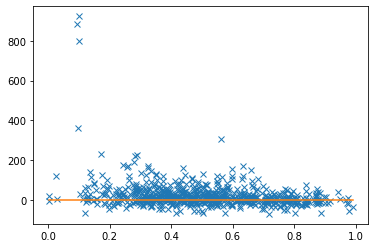

In [18]:
deficit = sigma - 10**ellipticals['sigma_ap']

var = BT

plt.figure()
plt.plot(var, deficit, 'x')
plt.plot([np.amin(var), np.amax(var)], [0,0])
plt.show()

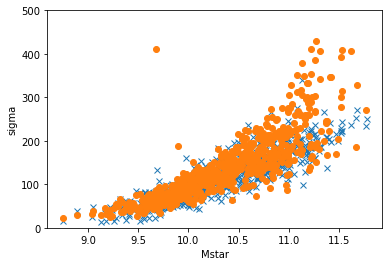

In [8]:
plt.figure()
plt.plot(ellipticals['Mstar'], 10**ellipticals['sigma_ap'], 'x')
plt.plot(ellipticals['Mstar'], sigma, 'o')
plt.ylim((0, 500))
plt.xlabel("Mstar")
plt.ylabel("sigma")
plt.show()

<Figure size 432x288 with 0 Axes>

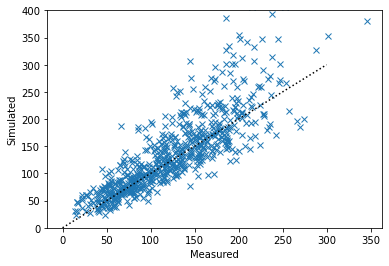

In [10]:
plt.figure()


plt.figure()
plt.plot(10**ellipticals['sigma_re'], sigma, 'x')
plt.xlabel("Measured")
plt.ylabel("Simulated")
plt.plot([0, 300], [0, 300], 'k:')
plt.ylim([0, 400])
plt.show()